In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns
import yaml
import pickle
import os
sns.set_context('paper', font_scale =1.5)

In [38]:
# relevant functions for the sequences
def adjacency_check(shape_sequence: np.array,shapes_no_target:list):
    """
    Checks whether any identical shapes are placed adjacently in a sequence and corrects for it

    Args:
        shape_sequence (np.array): shape sequence with no targets
        shapes_no_target (list): list of shapes without the target

    Returns:
        array: shape sequence fulfilling the adjacency rule
    """
    for i in range(len(shape_sequence) - 1):
        if shape_sequence[i] == shape_sequence[i + 1]:
        # Find a different letter to replace the adjacent duplicate
            for shape in shapes_no_target: #replacing with any other letter other than the target letter
                if shape != shape_sequence[i] and (i == 0 or shape != shape_sequence[i - 1]):
                    shape_sequence[i + 1] = shape
                    break
                    
    return shape_sequence


def place_targets_in_sequence(init_shape_sequence: np.array, target_shape: str,inter_targ_dist: int, max_target_dist: int, ind_to_avoid: list = None):
    """
    Places the target shape in the input sequence 

    Args:
        init_shape_sequence (np.array): initial shape sequence without targets
        target_shape (str): chosen target shape
        inter_targ_dist (int): minimum distance between two targets (in indices)
        max_target_dist (int): maximum possible distance between targets
        ind_to_avoid (list, optional): indices to be avoided when placing the targets. Used for non-cued sequences. Defaults to None.

    Returns:
        array: input sequence with targets at random positions
    """
    
    if ind_to_avoid is None:
        current_index = 0    
        while current_index < len(init_shape_sequence):
        
            if current_index == 0:
                # for the first target, we utilize the initial indices of the sequence
                tar_dist = np.random.choice(np.arange(2, len(init_shape_sequence) // 10))

            else:
                tar_dist = np.random.choice(np.arange(inter_targ_dist, max_target_dist))  # tar_dist now varies from inter_targ_dist to a max value

            # Ensure current_index + tar_dist does not exceed sequence_size
            if current_index + tar_dist < len(init_shape_sequence):
                init_shape_sequence[current_index + tar_dist] = target_shape
                current_index += tar_dist
            else:
                break
    else:
        
        current_index = 0    
        while current_index < len(init_shape_sequence):
        
            if current_index == 0:
                # for the first target, we utilize the initial indices of the sequence
                tar_dist = np.random.choice(np.arange(2, len(init_shape_sequence) // 10))

            else:
                tar_dist = np.random.choice(np.arange(inter_targ_dist, max_target_dist))  # tar_dist now varies from inter_targ_dist to a max value

            # Ensure current_index + tar_dist is not equal to any of the target indices in ind_to_avoid
            # If true, skips to next index and tries again 
            ind_avoid_condition = np.where(ind_to_avoid == (current_index + tar_dist))[0].size
            
            if ind_avoid_condition == 0:
                
                # Ensure current_index + tar_dist does not exceed sequence_size
                if (current_index + tar_dist) < len(init_shape_sequence):
                    init_shape_sequence[current_index + tar_dist] = target_shape
                    current_index += tar_dist
                else:
                    break
            else:
                current_index += 1
            
    shape_sequence_with_targets = init_shape_sequence
            
    return shape_sequence_with_targets

def break_if_matching_indices(a: list,b: list):
    """
    Checks if indices have matching values in two sequences and breaks the loop if yes
    
    a,b : sequences
    """
    match = 0
    matching_indices = []
    for i in range(len(a)):
        if a[i] == b[i]:
            match += 1
            if match >=1:
                print("matching indices")
                break


def gen_cued_non_cued_seq(init_shape_sequence: np.array, target_shape: str, inter_targ_dist: int, max_target_dist: int, shapes_no_target: list):
    """
    Generates the cued and the non_cued sequences

    Args:
        init_shape_sequence (np.array): initial shape sequence without targets
        target_shape (str): chosen target shape
        inter_targ_dist (int): minimum distance between two targets (in indices)
        max_target_dist (int): maximum possible distance between targets
        shapes_no_target (list): list of shapes without the target

    Returns:
        array: cued and non_cued sequences with targets
    """
    # adjacency check
    cued_seq_no_targ = adjacency_check(init_shape_sequence, shapes_no_target)
    
    # mapping each shape to another shape in the sequence - the cued and non_cued sequence should not have the same shape at the same index
    mapping_dict = dict(zip(shapes_no_target, shapes_no_target[1:] + shapes_no_target[:1]))
    
    # non_cued sequence (without targets), satisfies adjacency rule implicitly
    non_cued_seq_no_targ = [mapping_dict[shape] for shape in cued_seq_no_targ]

    
    # placing targets in cued sequence 
    cued_seq_targ = place_targets_in_sequence(cued_seq_no_targ, target_shape, inter_targ_dist, max_target_dist)

    # collecting indices at which targets were placed in the cued_sequence   
    targ_ind_cued = [ind for ind, shape in enumerate(cued_seq_targ) if shape == target_shape]   
    
    # placing targets in non_cued_sequence
    non_cued_seq_targ = place_targets_in_sequence(non_cued_seq_no_targ, target_shape, inter_targ_dist, max_target_dist, ind_to_avoid= targ_ind_cued)
    
    break_if_matching_indices(cued_seq_targ, non_cued_seq_targ)
    

    return cued_seq_targ, non_cued_seq_targ

   


In [39]:
# relevant function for visualization of sequence parameters: std deviation of target counts, and target count distributions
def visualize_seq_params(max_possible_dist:int, d_max_range: np.array, std_all_sequences: np.array, all_target_counts: np.array , sim_size:int, seq_type: str):
    """
    Plots the standard deviation of target counts and the target count distribution for all simulations 

    Args:
        max_possible_dist (int): maximum possible distance between two targets
        d_max_range (np.array): range of maximum distances between targets, starts from 10 and goes to max_possible_dist
        std_all_sequences (np.array): standard deviation of target counts (for cued or non_cued)
        all_target_counts (np.array): number of targets in sequences across all simulations
        sim_size (int): number of simulations
        seq_type (str): type of sequence (cued or non_cued)

    """
    
    # plotting variation of standard deviation
    plt.figure(figsize = (18, 4))
    cmap = plt.get_cmap('viridis')
    values = np.arange(10, max_possible_dist+1, 3)
    colors = [cmap((value - 10) / 30) for value in values]
    plt.subplot(121)
    for i in range(len(d_max_range)):
        plt.scatter(std_all_sequences[i],std_all_sequences[i], marker = '*', color = colors[i], label = f"max_targ_dist: {d_max_range[i]}")
    plt.title(f"std for all maximum distances, max std at d_max = {d_max_range[np.argmax(std_all_sequences)]}")
    plt.legend(bbox_to_anchor = (-.1,1))


    # plotting count distribution at maximum standard deviation
    data = all_target_counts[np.argmax(std_all_sequences)]
    mu, std = norm.fit(data)
    plt.subplot(122)
    plt.hist(data, bins=25, density=True, alpha=0.2, color='green')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, color='green', linewidth=3)
    plt.title(f"{seq_type}: target count distribution for {sim_size} simulations at max std")
    plt.xlabel('number of targets')
    plt.ylabel('target frequency')
    plt.show()
    
    return np.max(std_all_sequences), d_max_range[np.argmax(std_all_sequences)]


## Explanation: 
    1. We are generating sequences where targets can be placed at a maximum of D spaces apart. 

    2. This maximum possible distance between targets is varied, and for each variation, we generate a total of N sequences

    3. We then find the target count for each of the D x N sequences, and compute a distribution of this count. 

    4. The optimum value for the maximum target distance, d_max, corresponding to the maximum standarad deviation of these count distributions is chosen as the final parameter to generate the sequences used in our experiment.

**Note**: This notebook will use the terms "cued" and "non_cued" sequences throughout. The "cued" sequences are the shape sequences that the subject will covertly/overtly pay attention to during a trial, and the "non_cued" sequences are the sequences that are not attended to. This terminology is limited to an offline protocol. In an online protocol, there will be no such difference as the cued and non_cued sequences. Target balancing (see next explanation section) will then be done for both categories of sequences.

In [40]:
# Parameters
project_path = r'C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_experiment\experiment_version_2'
with open(os.path.join(project_path,'config.yml'), "r") as yaml_file:
    config_data = yaml.safe_load(yaml_file)
    
# load constants
experiment_params = config_data['experimental_params']
SHAPES = experiment_params['SHAPES']
FR = experiment_params['FR']
TRIAL_TIME = experiment_params['TRIAL_TIME']

# compute parameters
shape_change_time_sec = .250 # The duration (sec) between the occurrance of two different shapes
total_frames = int(TRIAL_TIME*FR) # Total frames in a trial    
change_shapes = int(shape_change_time_sec*FR)  # The number of frames after which a new shape will appear inside the circle
sequence_size = int(np.ceil(total_frames /change_shapes)) # size of sequence
target_shape = SHAPES[-1]
inter_targ_dist = 6 # the difference in indices between two target positions

# Initialize sequence
shapes_no_target = [shape for shape in SHAPES if shape != target_shape]
init_shape_sequence = np.random.choice(shapes_no_target, size=sequence_size).tolist()

# Simulation param or 'N'
sim_size = 2000

# Maximum distance between targets param
D = 40
d_max_range = np.arange(10, D +1, 3)
print("max possiblle distance between targets:", max(d_max_range))

# sequence params
all_sequences_cued = np.zeros((len(d_max_range), sim_size, sequence_size), dtype = 'object')
all_sequences_non_cued = np.zeros((len(d_max_range), sim_size, sequence_size), dtype = 'object')

# target count params
all_target_counts_cued = np.zeros((len(d_max_range), sim_size)) 
all_target_counts_non_cued = np.zeros((len(d_max_range), sim_size)) 

# generating D x N sequences
for i_max_dist, max_dist in enumerate(d_max_range):

    for i_sim in range(sim_size):
        init_shape_sequence = np.random.choice(shapes_no_target, size=sequence_size)
        
        # generating cued and non_cued sequences
        cued_seq_targ, non_cued_seq_targ = gen_cued_non_cued_seq(init_shape_sequence = init_shape_sequence, target_shape = target_shape, 
                                                         inter_targ_dist = inter_targ_dist, max_target_dist = max_dist, 
                                                         shapes_no_target = shapes_no_target)
               
        # checking if the generated sequence meets our criteria (the difference between all target indices should be atleast the minimum distance)
        
        # cued
        target_indices_cued = [index for index, shape in enumerate(cued_seq_targ) if shape == target_shape]
        diff_cued = np.diff(target_indices_cued)
        
        # non_cued
        target_indices_non_cued = [index for index, shape in enumerate(non_cued_seq_targ) if shape == target_shape]
        diff_non_cued = np.diff(target_indices_non_cued)
        
        if np.all(diff_cued >= inter_targ_dist) and np.all(diff_non_cued >= inter_targ_dist):
            all_sequences_cued[i_max_dist, i_sim] = cued_seq_targ
            all_target_counts_cued[i_max_dist, i_sim] = len(target_indices_cued) # number of targets in the sequence
            
            all_sequences_non_cued[i_max_dist, i_sim] = non_cued_seq_targ
            all_target_counts_non_cued[i_max_dist, i_sim] = len(target_indices_non_cued) # number of targets in the sequence
            
        # checking if the generated sequence meets our criteria (the difference between all target indices should be atleast the minimum distance)
        
        # cued
        target_indices_cued = [index for index, shape in enumerate(cued_seq_targ) if shape == target_shape]
        diff_cued = np.diff(target_indices_cued)
        
        # non_cued
        target_indices_non_cued = [index for index, shape in enumerate(non_cued_seq_targ) if shape == target_shape]
        diff_non_cued = np.diff(target_indices_non_cued)
        
        if np.all(diff_cued >= inter_targ_dist) and np.all(diff_non_cued >= inter_targ_dist):
            all_sequences_cued[i_max_dist, i_sim] = cued_seq_targ
            all_target_counts_cued[i_max_dist, i_sim] = len(target_indices_cued) # number of targets in the sequence
            
            all_sequences_non_cued[i_max_dist, i_sim] = non_cued_seq_targ
            all_target_counts_non_cued[i_max_dist, i_sim] = len(target_indices_non_cued) # number of targets in the sequence
            

print("shape of all sequences",all_sequences_cued.shape)
print("target count for all simulations", all_target_counts_cued.shape)
            

print("shape of all sequences",all_sequences_cued.shape)
print("target count for all simulations", all_target_counts_cued.shape)

max possiblle distance between targets: 40
shape of all sequences (11, 2000, 80)
target count for all simulations (11, 2000)
shape of all sequences (11, 2000, 80)
target count for all simulations (11, 2000)


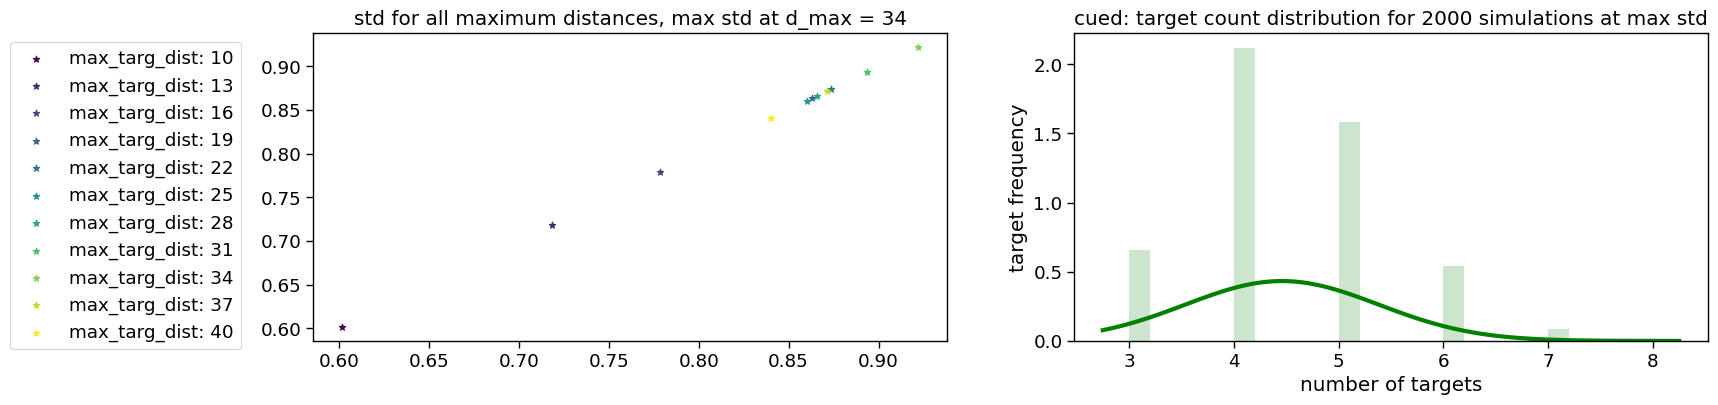

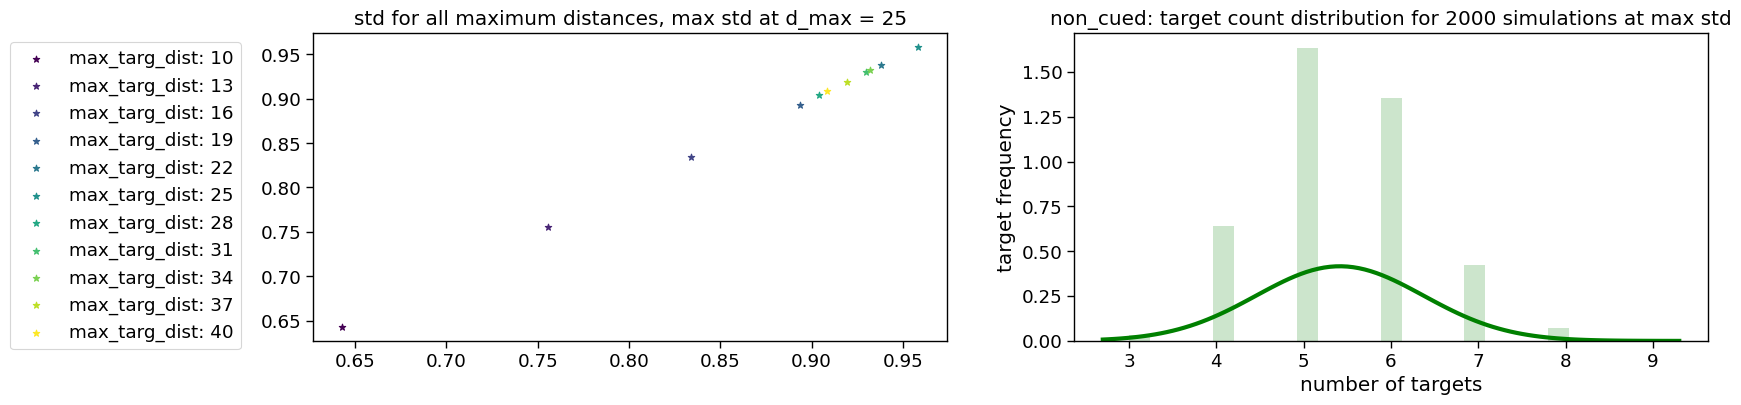

In [44]:
# Computing standard deviation of target counts
std_all_sequences_cued = np.zeros((len(d_max_range),))
std_all_sequences_non_cued = np.zeros((len(d_max_range),))

for i in range(len(d_max_range)):
    # cued
    data_cued = all_target_counts_cued[i]
    _, std_cued = norm.fit(data_cued)
    std_all_sequences_cued[i] =  std_cued
    
    # non_cued
    data_non_cued = all_target_counts_non_cued[i]
    _, std_non_cued = norm.fit(data_non_cued)
    std_all_sequences_non_cued[i] =  std_non_cued

    

# plotting variation of standard deviation and target count distribution
std_max_cued, d_max_cued = visualize_seq_params(max_possible_dist = D, 
                     d_max_range = d_max_range, 
                     std_all_sequences = std_all_sequences_cued,
                     all_target_counts= all_target_counts_cued ,
                     sim_size = sim_size, 
                     seq_type = 'cued')

std_max_non_cued, d_max_non_cued = visualize_seq_params(max_possible_dist = D, 
                     d_max_range = d_max_range, 
                     std_all_sequences =std_all_sequences_non_cued, 
                     all_target_counts= all_target_counts_non_cued, 
                     sim_size = sim_size, 
                     seq_type = 'non_cued')


#### Balancing target counts for left and right cued_sequences 

    1.The p300 response ellicited by the shape sequences need to be balanced for both cued sides

    2.This is done by first randomly selecting some sequences (sequence A), and then selecting another set of sequences (sequence B) such that the sum of target counts of both these sequence sets are equal.

**Note**: The splitting of cued sequences to the left or right side is only relevant for balancing. Once this is done, they can be arbritrarily used for either of the sides irrespective of which sequence set (right or left) they initially belonged to. The non_cued sequences also undergo target balancing as this would be necessary in an online setting.


In [45]:
def balance_target_counts(initial_indices: np.array, seq_max_sd: np.array, target_counts_seq_max_sd: np.array, total_trials: int):
    """
    Balances target counts for the left and right cued sequences for a single participant
    
    Args:
        initial_indices (np.array): indices of shape sequences appearing on the right side. Randomly chosen for a participant
        seq_max_sd (np.array): cued sequences with the maximum std in their target counts
        target_counts_seq_max_sd (np.array): corresponding target counts of the above sequences
        total_trials_cued (int, optional): number of total cued trials in an experiment.

    Returns:
        dict: two dict objects containing sequence and target count information
    """
    # sequences for the right side
    sequence_A = seq_max_sd[initial_indices]
    target_counts_sequence_A = target_counts_seq_max_sd[initial_indices]

    # selecting target counts for the left side such that the sum of target counts is equal on both sides (balancing)
    target_counts_sum_seq_B = 0
    while target_counts_sum_seq_B != np.sum(target_counts_sequence_A): # compare sum
        indices_seq_B= np.random.choice(np.arange(len(target_counts_seq_max_sd)), size = total_trials// 2) # choose 40 random indices
        target_counts_sum_seq_B = np.sum(target_counts_seq_max_sd[indices_seq_B]) # compute sum

    # getting sequences and target counts for the left side
    sequence_B = seq_max_sd[indices_seq_B]
    target_counts_sequence_B = target_counts_seq_max_sd[indices_seq_B]
    
    # concatenating sequences and their target info
    all_seq = np.concatenate([sequence_A, sequence_B])
    all_target_counts = np.concatenate([target_counts_sequence_A,target_counts_sequence_B])
    
    
    return all_seq, all_target_counts

#### Storing sequence and target info for P participants

In [46]:
# 1. selecting the sequences with maximum standard deviation
cued_seq_max_sd = all_sequences_cued[np.argmax(std_all_sequences_cued)]
non_cued_seq_max_sd = all_sequences_non_cued[np.argmax(std_all_sequences_non_cued)]

# 2. number of targets in the corresponding sequences with maximum standard deviation
target_counts_cued_max_sd = all_target_counts_cued[np.argmax(std_all_sequences_cued)]

# 3. targets in the corresponding non_cued_sequences
target_counts_non_cued_max_sd = all_target_counts_non_cued[np.argmax(std_all_sequences_non_cued)]

# Parameters for the experiment 
P = 40 # number of participants
n_runs_cov = 4 # total number of blocks/ runs (4 covert + 1 overt)
n_runs_ov = 1
n_trials = 20 # total trials

# Number of cued and non_cued sequences in an experiment = n_runs x n_trials

# number of sequences: covert (cov)
total_seq_cued_cov = n_runs_cov * n_trials
total_seq_non_cued_cov = n_runs_cov * n_trials

# number of sequences: overt (ov)
total_seq_cued_ov = n_runs_ov * n_trials
total_seq_non_cued_ov = n_runs_ov * n_trials

# looping over participants and storing sequence information for both overt (no balancing needed) and covert conditions
for i_par in range(P):
    
    #overt: cued sequences (no balancing needed, but could be added easily. see covert sections below)
    cued_indices_ov = np.random.choice(np.arange(len(cued_seq_max_sd)),size = total_seq_cued_ov)# sequence indices
    cued_seq_ov = cued_seq_max_sd[cued_indices_ov]# sequences
    cued_targ_counts_ov = target_counts_cued_max_sd[cued_indices_ov]# target counts
    
    # overt: non_cued sequences
    non_cued_indices_ov = np.random.choice(np.arange(len(non_cued_seq_max_sd)),size = total_seq_cued_ov) # sequence indices
    non_cued_seq_ov = cued_seq_max_sd[non_cued_indices_ov] # sequences
    non_cued_targ_counts_ov = target_counts_cued_max_sd[non_cued_indices_ov] # target counts
    
    # covert: select a set of indices for balancing target counts
    initial_indices_cued = np.random.choice(len(cued_seq_max_sd), size = total_seq_cued_cov // 2)
    
    # getting all cued sequences and their target count info
    cued_seq_cov, cued_targ_counts_cov = balance_target_counts(initial_indices= initial_indices_cued, 
                                                        seq_max_sd = cued_seq_max_sd, 
                                                        target_counts_seq_max_sd = target_counts_cued_max_sd, 
                                                        total_trials = total_seq_cued_cov)
    
    # covert: non_cued sequences
    initial_indices_non_cued = np.random.choice(len(non_cued_seq_max_sd), size = total_seq_non_cued_cov // 2) 
    
    # getting all non_cued sequences and their target count info
    non_cued_seq_cov, non_cued_targ_counts_cov = balance_target_counts(initial_indices= initial_indices_non_cued, 
                                                        seq_max_sd = non_cued_seq_max_sd, # pick sequences from the non_cued sequences
                                                        target_counts_seq_max_sd = target_counts_non_cued_max_sd, 
                                                        total_trials = total_seq_non_cued_cov)
    
    # collecting info for participant P: overt
    P_seq_info_ov = {'cued_sequences':cued_seq_ov, 'non_cued_sequences': non_cued_seq_ov}
    P_target_count_info_ov = {'cued_target_counts': cued_targ_counts_ov, 'non_cued_target_counts': non_cued_targ_counts_ov}
    P_all_info_ov = {'sequence_info': P_seq_info_ov, 'target_count_info': P_target_count_info_ov}
    
    # collecting info for participant P: covert
    P_seq_info_cov = {'cued_sequences':cued_seq_cov, 'non_cued_sequences': non_cued_seq_cov}
    P_target_count_info_cov = {'cued_target_counts': cued_targ_counts_cov, 'non_cued_target_counts': non_cued_targ_counts_cov}
    P_all_info_cov = {'sequence_info': P_seq_info_cov, 'target_count_info': P_target_count_info_cov}
    
    # saving
    fn_ov = rf"C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_experiment\experiment_version_2\shape_sequences\P{i_par+1}_overt.pickle"
    with open(fn_ov, 'wb') as handle:
        pickle.dump(P_all_info_ov, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # saving
    fn_cov = rf"C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_experiment\experiment_version_2\shape_sequences\P{i_par+1}_covert.pickle"
    with open(fn_cov, 'wb') as handle:
        pickle.dump(P_all_info_ov, handle, protocol=pickle.HIGHEST_PROTOCOL)
    